# Verify

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import cv2
%matplotlib inline

In [2]:
vgg_model = tf.keras.models.load_model('vgg_finetuned_model.keras', compile=False)
feature_extractor = tf.keras.Sequential(vgg_model.layers[:-1])

In [33]:
def load_image(image_path, upscale_factor=2):
    '''Return the image in the format required by VGG16 model, optionally upscaled.'''
    # Load the original image
    img = cv2.imread(image_path)
    
    # Upscale the image
    if upscale_factor > 1:
        height, width = img.shape[:2]
        img = cv2.resize(img, (width * upscale_factor, height * upscale_factor), interpolation=cv2.INTER_CUBIC)
    
    # Resize to VGG16 input size
    img = cv2.resize(img, (224, 224))
    
    # Convert to array and preprocess
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_features(paths):
    '''Returns the features extracted by the model.'''
    feature_list = []
    for images in paths:
        features = {}
        features['anchor'] = feature_extractor.predict(load_image(images[0]))
        features['other'] = feature_extractor.predict(load_image(images[1]))
        feature_list.append(features)
    return feature_list

def cosine_similarity_fn(feature_list):
    '''Returns the cosine similarity between the two signature images.'''
    cosine_similarities = []
    for features in feature_list:
        similarity = cosine_similarity(features['other'], features['anchor'])[0][0]
        cosine_similarities.append(similarity)
    return cosine_similarities

def interpret_confidence(cosine_similarity, threshold=0.9):
    if cosine_similarity >= threshold:
        return f"High confidence"
    else:
        return f"Low confidence"

In [59]:
image_pairs = [['region1.jpg', 'region2.jpg']]

feature_set = extract_features(image_pairs)
cosine_similarities = cosine_similarity_fn(feature_set)
confidence = interpret_confidence(cosine_similarities[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


**Ploting Sample Signature Pairs**

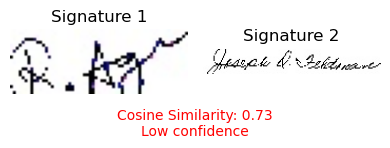

In [60]:
# Create a single figure for the two cropped images
fig, axs = plt.subplots(1, 2, figsize=(4, 1.5), facecolor='w', edgecolor='k')

# Display the first cropped image
axs[0].imshow(plt.imread(image_pairs[0][0]))
axs[0].set_title('Signature 1')
axs[0].axis('off')  # Hide axes

# Display the second cropped image
axs[1].imshow(plt.imread(image_pairs[0][1]))
axs[1].set_title('Signature 2')
axs[1].axis('off')  # Hide axes

# Print the cosine similarity score
text_color = "green" if cosine_similarities[0] >= 0.9 else "red"
plt.figtext(0.5, 0.01, f'Cosine Similarity: {cosine_similarities[0]:.2f}\n{confidence}', ha='center', fontsize=10,color=text_color)

plt.tight_layout()
plt.show()